In [1]:
# change into root directory to the project
import os
os.chdir('..')

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from neurolib.models.aln import ALNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution
import neurolib.utils.functions as func

#import neurolib. as du

# sett dpi for notebooks on server
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['image.cmap'] = 'plasma'

/Users/caglar/anaconda/lib/python3.7/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [4]:
alnModel = ALNModel(simulateBOLD=True)
alnModel.run()

INFO:root:Model aln created


In [5]:
alnModel.outputs

{'rates': {'t': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 1.9998e+03, 1.9999e+03,
         2.0000e+03]),
  'rates_exc': array([[2.21555935, 2.39759877, 2.50367673, ..., 1.16393113, 1.12422915,
          1.08458447]]),
  'rates_inh': array([[60.63934573, 57.34191579, 55.89026472, ...,  7.08372341,
           6.9826411 ,  6.87986958]])},
 'BOLD': {'t': array([0.1]), 'BOLD': array([[1.37354628e-10]])}}

In [12]:
def evaluateSimulation(traj):
    rid = traj.id
    logging.info("Running run id {}".format(rid))

    model = evolution.getModelFromTraj(traj)
    
    model.params['dt'] = 0.1
    model.params['duration'] = 2*1000.
        
    model.run()
    
    # -------- fitness evaluation here --------
    
    # example: get dominant frequency of activity
    frs, powers = func.getPowerSpectrum(model.rates_exc[:, -int(1000/model.params['dt']):], model.params['dt'])
    domfr = frs[np.argmax(powers)]
    
    fitness = abs(domfr - 25) # let's try to find a 25 Hz oscillation
    
    fitness_tuple = ()
    fitness_tuple += (fitness,)
    return fitness_tuple, model.outputs

In [13]:
pars = ParameterSpace(['mue_ext_mean', 'mui_ext_mean'], [[0.0, 4.0], [0.0, 4.0]])
evolution = Evolution(evaluateSimulation, pars, model = alnModel, weightList = [-1.0], POP_INIT_SIZE=20, POP_SIZE = 10, NGEN=15)
evolution.run(verbose = False)

MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2020-01-31-18H-14M-50S
MainProcess root INFO     Number of cores: 8
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
/Users/caglar/anaconda/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/caglar/anaconda/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
MainProcess root INFO     Evaluating initial population of size 20 ...
MainProcess pypet.trajectory.Trajectory INFO     Y

# Analysis

In [14]:
evolution.info(plot=False)

Parameters dictribution (Generation 14):
mue_ext_mean: 	 mean: 1.258,	 std: 0.08749
mui_ext_mean: 	 mean: 0.331,	 std: 0.1209
Printing 10 individuals
Individual 0 pars mue_ext_mean 1.3, mui_ext_mean 0.3307
	Fitness values:  0.0
Individual 1 pars mue_ext_mean 1.326, mui_ext_mean 0.3716
	Fitness values:  1.0
Individual 2 pars mue_ext_mean 1.306, mui_ext_mean 0.381
	Fitness values:  1.0
Individual 3 pars mue_ext_mean 1.201, mui_ext_mean 0.3538
	Fitness values:  1.0
Individual 4 pars mue_ext_mean 1.238, mui_ext_mean 0.2511
	Fitness values:  1.0
Individual 5 pars mue_ext_mean 1.312, mui_ext_mean 0.3675
	Fitness values:  1.0
Individual 6 pars mue_ext_mean 1.265, mui_ext_mean 0.2668
	Fitness values:  1.0
Individual 7 pars mue_ext_mean 1.181, mui_ext_mean 0.4719
	Fitness values:  3.0
Individual 8 pars mue_ext_mean 1.063, mui_ext_mean 0.03518
	Fitness values:  3.0
Individual 9 pars mue_ext_mean 1.389, mui_ext_mean 0.4803
	Fitness values:  3.0


In [15]:
# This will load results from disk in case the session is 
# started newly and the trajectory is not in memory
traj = evolution.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/evolution.hdf
MainProcess root INFO     Analyzing trajectory results-2020-01-31-18H-14M-50S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2020-01-31-18H-14M-50S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `derived_parameters` in mode `1`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.


In [16]:
gens, all_scores = evolution.getScoresDuringEvolution()

Text(0, 0.5, 'Score')

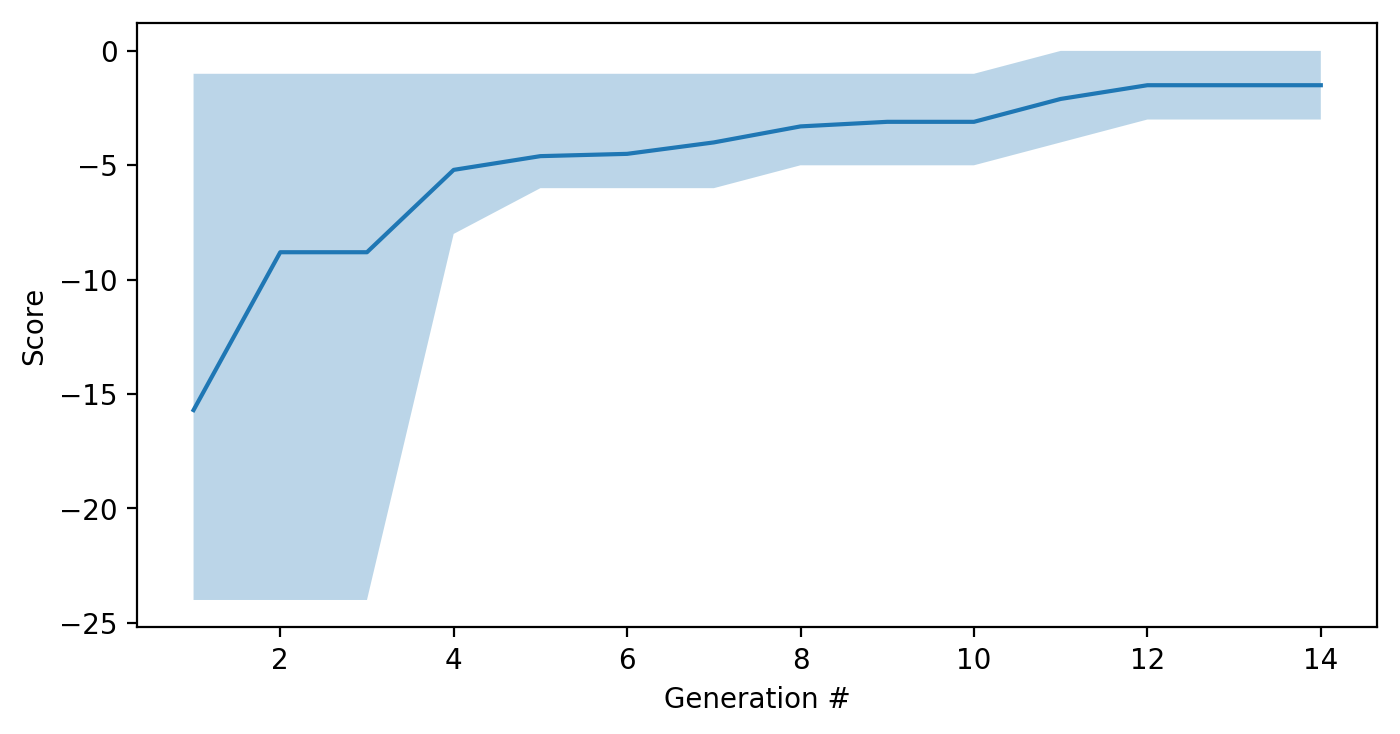

In [17]:
plt.figure(figsize=(8, 4), dpi=200)   
plt.plot(gens, np.nanmean(all_scores, axis=1))
plt.fill_between(gens, np.nanmin(all_scores, axis=1), np.nanmax(all_scores, axis=1), alpha=0.3)
plt.xlabel("Generation #")
plt.ylabel("Score")

In [36]:
import dill
# if we're lazy, we can just dump the whole evolution object into a file
dill.dump(evolution, open("/Users/caglar/tmp/evolution.dill", "wb"))